In [ ]:
pip install catboost

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


===== Train / Test Accuracy =====
CatBoost  → train: 1.000, test: 0.750
Logistic  → train: 0.860, test: 0.771
LDA       → train: 0.838, test: 0.698
QDA       → train: 0.689, test: 0.625


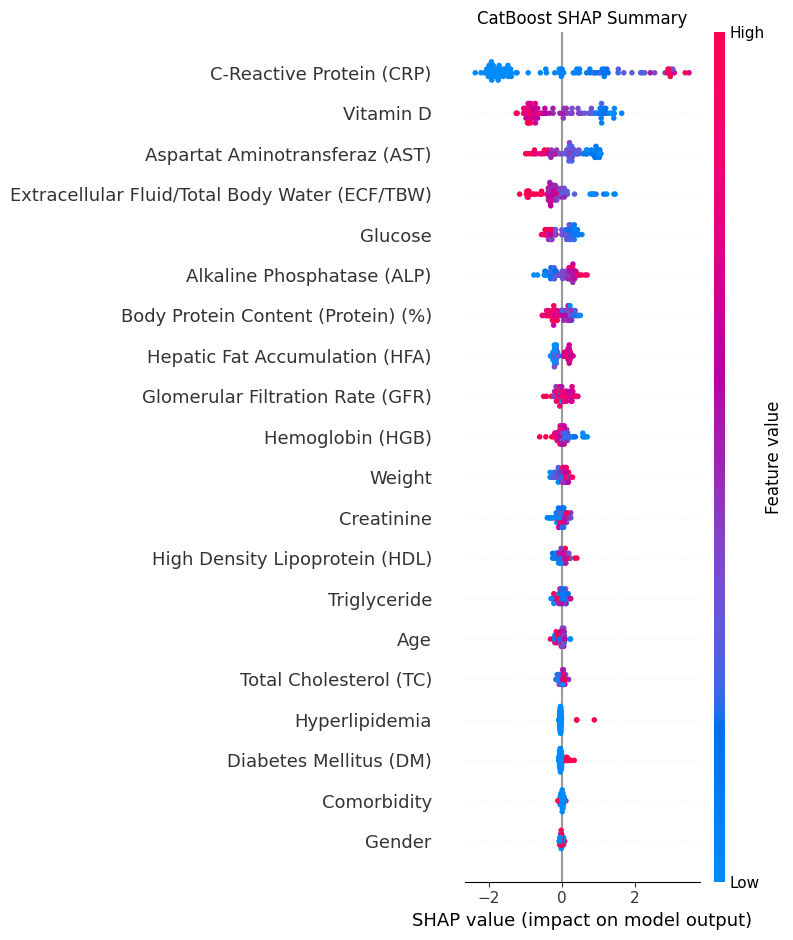

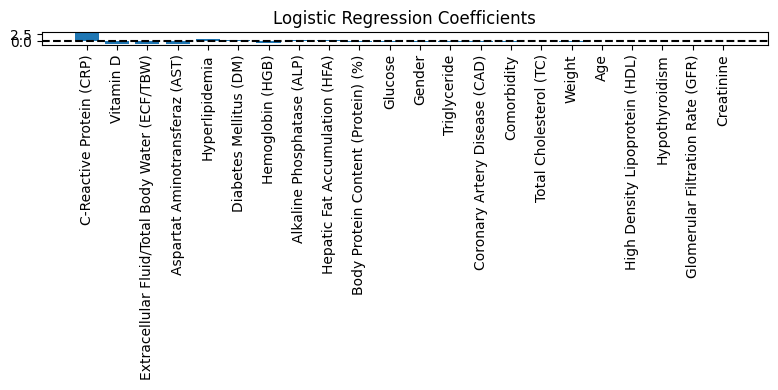


[LDA] 클래스별 평균 벡터:
 class 0: [-0.034 -0.143  0.084  0.101 -0.001 -0.152 -0.094 -0.054  0.197  0.054
 -0.095  0.005 -0.044 -0.174  0.07   0.213 -0.183  0.122 -0.007 -0.388
  0.204  0.397]
 class 1: [ 0.034  0.145 -0.085 -0.103  0.002  0.155  0.095  0.055 -0.201 -0.055
  0.096 -0.005  0.045  0.177 -0.071 -0.217  0.187 -0.125  0.007  0.395
 -0.208 -0.404]
LDA scalings: [ 0.008 -0.278 -0.129 -0.099  0.107  0.316  0.383 -0.122 -0.512 -0.159
  0.304 -0.204  0.133  0.027 -0.229 -0.242  0.263 -0.215 -0.193  0.495
 -0.246 -0.668]


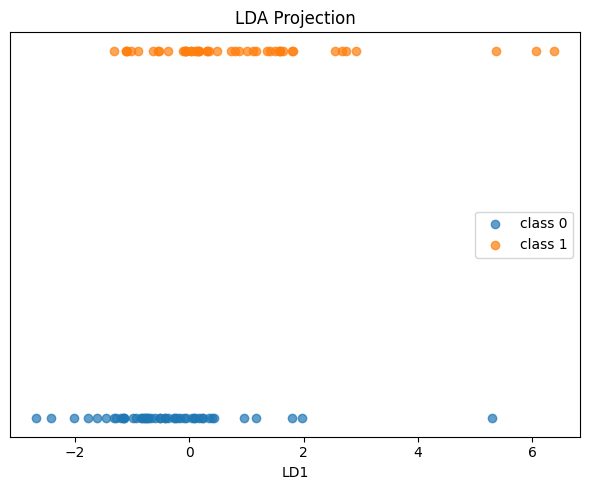


[QDA] 클래스별 평균 벡터:
 class 0: [-0.034 -0.143  0.084  0.101 -0.001 -0.152 -0.094 -0.054  0.197  0.054
 -0.095  0.005 -0.044 -0.174  0.07   0.213 -0.183  0.122 -0.007 -0.388
  0.204  0.397]
 class 1: [ 0.034  0.145 -0.085 -0.103  0.002  0.155  0.095  0.055 -0.201 -0.055
  0.096 -0.005  0.045  0.177 -0.071 -0.217  0.187 -0.125  0.007  0.395
 -0.208 -0.404]

[QDA] 클래스별 공분산 행렬:
 class 0 covariance:
[[ 1.173e+00 -0.000e+00  4.890e-01  3.090e-01 -3.500e-02  0.000e+00
   2.330e-01  2.380e-01  4.170e-01  1.070e-01  2.650e-01  3.410e-01
   2.150e-01 -2.100e-02  1.560e-01 -6.500e-02  1.500e-02  2.120e-01
  -7.180e-01  2.500e-02 -6.900e-02 -2.700e-02]
 [-0.000e+00  9.730e-01 -1.080e-01 -1.800e-02  2.000e-01 -0.000e+00
  -9.500e-02 -4.030e-01  3.740e-01 -3.170e-01 -2.020e-01 -4.100e-02
  -6.000e-03  4.820e-01 -3.620e-01 -3.070e-01  8.100e-02 -6.930e-01
   1.750e-01  3.100e-02 -6.780e-01  3.500e-02]
 [ 4.890e-01 -1.080e-01  1.247e+00  6.500e-01  1.740e-01  0.000e+00
   3.730e-01  1.610e-01  1.820e-01

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection            import train_test_split
from sklearn.preprocessing             import StandardScaler
from catboost                          import CatBoostClassifier
from sklearn.linear_model              import LogisticRegression
from sklearn.discriminant_analysis     import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics                   import accuracy_score
import matplotlib.pyplot               as plt
import shap

# 0) 설정
DATA_PATH = "dataset-uci 2.xls"
DROP_ROW  = 22   # 0-based index

# 1) 데이터 로딩 & 전처리
df = pd.read_excel(DATA_PATH)
df = df.drop(df.index[DROP_ROW])
df = df.drop('Obesity (%)', axis=1)

# 2) 사용할 피처 리스트
features = [
    'Age', 'Gender', 'Comorbidity', 'Coronary Artery Disease (CAD)',
    'Hypothyroidism', 'Hyperlipidemia', 'Diabetes Mellitus (DM)',
    'Weight', 'Extracellular Fluid/Total Body Water (ECF/TBW)',
    'Body Protein Content (Protein) (%)', 'Hepatic Fat Accumulation (HFA)',
    'Glucose', 'Total Cholesterol (TC)', 'High Density Lipoprotein (HDL)',
    'Triglyceride', 'Aspartat Aminotransferaz (AST)', 'Alkaline Phosphatase (ALP)',
    'Creatinine', 'Glomerular Filtration Rate (GFR)', 'C-Reactive Protein (CRP)',
    'Hemoglobin (HGB)', 'Vitamin D'
]

X = df[features].values
y = df.iloc[:, 0].values

# 3) train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# 4) 표준화
scaler      = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)


# 5) 모델 정의 & 학습
cb = CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6,
                        eval_metric='Accuracy', random_seed=0, verbose=False)
cb.fit(X_train_std, y_train, eval_set=(X_test_std, y_test))

lr = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=0)
lr.fit(X_train_std, y_train)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_std, y_train)

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train_std, y_train)


# 6) 성능 비교
models = {'CatBoost':cb, 'Logistic':lr, 'LDA':lda, 'QDA':qda}
print("===== Train / Test Accuracy =====")
for name, model in models.items():
    tr = accuracy_score(y_train, model.predict(X_train_std))
    te = accuracy_score(y_test,  model.predict(X_test_std))
    print(f"{name:9s} → train: {tr:.3f}, test: {te:.3f}")


# 7-1) CatBoost SHAP
explainer   = shap.TreeExplainer(cb)
shap_values = explainer.shap_values(X_test_std)
shap.summary_plot(shap_values, X_test_std, feature_names=features, show=False)
plt.title("CatBoost SHAP Summary")
plt.tight_layout()
plt.show()

# 7-2) Logistic 회귀 계수
coef = lr.coef_[0]
idx  = np.argsort(np.abs(coef))[::-1]
plt.figure(figsize=(8,4))
plt.bar([features[i] for i in idx], coef[idx])
plt.xticks(rotation=90)
plt.axhline(0, color='black', linestyle='--')
plt.title("Logistic Regression Coefficients")
plt.tight_layout()
plt.show()


# 7-3) LDA: 클래스별 평균 & 투영 시각화
print("\n[LDA] 클래스별 평균 벡터:")
for i, mu in enumerate(lda.means_):
    print(f" class {i}: {np.round(mu,3)}")
print("LDA scalings:", np.round(lda.scalings_.ravel(),3))

X_lda = lda.transform(X_test_std)
n_comp = X_lda.shape[1]

plt.figure(figsize=(6,5))
if n_comp >= 2:
    # 2D
    for cls in np.unique(y_test):
        plt.scatter(
            X_lda[y_test==cls,0],
            X_lda[y_test==cls,1],
            label=f"class {cls}", alpha=0.7
        )
    plt.xlabel("LD1"); plt.ylabel("LD2")
else:
    # 1D
    offsets = np.linspace(-0.1, 0.1, len(np.unique(y_test)))
    for cls, off in zip(np.unique(y_test), offsets):
        xi = X_lda[y_test==cls,0]
        yi = np.zeros_like(xi) + off
        plt.scatter(xi, yi, label=f"class {cls}", alpha=0.7)
    plt.xlabel("LD1")
    plt.yticks([])
plt.title("LDA Projection")
plt.legend()
plt.tight_layout()
plt.show()


# 7-4) QDA 평균 & 공분산
print("\n[QDA] 클래스별 평균 벡터:")
for i, mu in enumerate(qda.means_):
    print(f" class {i}: {np.round(mu,3)}")

print("\n[QDA] 클래스별 공분산 행렬:")
for i, cov in enumerate(qda.covariance_):
    print(f" class {i} covariance:\n{np.round(cov,3)}\n")
